# Financial variables that impact BorrowerRates

## Investigation Overview

The project will revolve around the investigation of home loans and the factors that directly impact the borrow rates provided by financial lending institutions, in this case Prosper, to lendees. The main exploratory  variables from the available data set were:
- EmploymentStatus
- BorrowerState
- Occupation
- CreditGrade / ProsperRating (alpha) / ProsperRating (numeric)
- ProsperScore
- IncomeRange
- Term
- CurrentDelinquencies
- BorrowerRate
- DebtToIncomeRatio
- MonthlyLoanRepayment
- ListingCreationDate
- ClosedDate

However of the above variables, only a select few proved to be influential to  affecting borrow rates.
- EmploymentStatus
- IncomeRange
- CreditRating
- Occupation

## Dataset Overview

The loans dataset provides 113,937 loan listings provided by Prosper across the span of 8 years between the periods of 2009 and 2014. There are 81 variables in total of which were trimmed down to the variables previously mentioned above.
**ProsperRatings** and **CreditGrades** variables cater to different time periods and were merged, similarly with **ProsperRating (numerical)** in order to reduce *Nan* values, as seen in the next plot.

There were several category values that provided little to no information to the analysis and were purged, for instance employment types such as *Employed* and *Other*.



In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.ticker as ticker

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
# Local via drive read csv
loans_raw = pd.read_csv('prosperLoanData.csv')

In [3]:
# reload loans_df with the relevant columns, loans_raw contains the original
loans_df = loans_raw.copy()

### Functions

In [4]:
# FUNCTION TO PLOT VALS ALONG X-AXIS, NOMINAL VALS ON Y
def yplot_values(gx, form):
    initialx = 0

    for g in gx.patches:
        gx.text(g.get_width(), initialx + g.get_height()/4,
                form.format(g.get_width()),
                color='black',
                ha="left") 
        initialx+=1

# FUNCTION TO PLOT VALS ALONG Y-AXIS, NOMINAL VALS ON X
def xplot_values(gy, form):
    initialy = 0
    
    # Logic to print the proportion text on the bars
    for g in gy.patches:
        gy.text(initialy + g.get_width()/13, g.get_height(), 
        form.format(g.get_height()), 
        color='black',
        ha='center', # 'center', 'right', 'left'
        va='bottom') # 'top', 'bottom', 'center', 'baseline', 'center_baseline'
        initialy+=1

In [5]:
# create list
subset = ['EmploymentStatus', 'BorrowerState', 'Occupation', 
'CreditGrade', 'ProsperRating (Alpha)', 'ProsperRating (numeric)',
'IncomeRange', 'Term', 'CurrentDelinquencies', 'BorrowerRate', 'DebtToIncomeRatio', 
'ListingCreationDate', 'ClosedDate', 'MonthlyLoanPayment']

# 'ListingCategory (numeric)', - removed to be added later

subset, print('Number of Target Columns: {}\n'.format(len(subset)))

Number of Target Columns: 14



(['EmploymentStatus',
  'BorrowerState',
  'Occupation',
  'CreditGrade',
  'ProsperRating (Alpha)',
  'ProsperRating (numeric)',
  'IncomeRange',
  'Term',
  'CurrentDelinquencies',
  'BorrowerRate',
  'DebtToIncomeRatio',
  'ListingCreationDate',
  'ClosedDate',
  'MonthlyLoanPayment'],
 None)

In [6]:
# reload loans_df with the relevant columns, loans_raw contains the original
loans_df = loans_raw.loc[:, subset].copy()
loans_df.head()

,EmploymentStatus,BorrowerState,Occupation,CreditGrade,ProsperRating (Alpha),ProsperRating (numeric),IncomeRange,Term,CurrentDelinquencies,BorrowerRate,DebtToIncomeRatio,ListingCreationDate,ClosedDate,MonthlyLoanPayment
0,Self-employed,CO,Other,C,NaN,NaN,"$25,000-49,999",36,2.0,0.1580,0.17,2007-08-26 19:09:29.263000000,2009-08-14 00:00:00,330.43
1,Employed,CO,Professional,NaN,A,6.0,"$50,000-74,999",36,0.0,0.0920,0.18,2014-02-27 08:28:07.900000000,NaN,318.93
2,Not available,GA,Other,HR,NaN,NaN,Not displayed,36,1.0,0.2750,0.06,2007-01-05 15:00:47.090000000,2009-12-17 00:00:00,123.32
3,Employed,GA,Skilled Labor,NaN,A,6.0,"$25,000-49,999",36,4.0,0.0974,0.15,2012-10-22 11:02:35.010000000,NaN,321.45
4,Employed,MN,Executive,NaN,D,3.0,"$100,000+",36,0.0,0.2085,0.26,2013-09-14 18:38:39.097000000,NaN,563.97


#### Datatypes

 ##### Date time correction

In [7]:
# convert to correct data types
## dates
toDates = ['ListingCreationDate', 'ClosedDate'] # date mask
loans_df[toDates] = loans_df[toDates].astype('datetime64')

 ##### Date Year and Month extraction

In [8]:
# Extract year and month as ProsperRating and CreditGrade vary with year and month
loans_df['ListingCreationYear'] = pd.DatetimeIndex(loans_df.ListingCreationDate).year
loans_df['ListingCreationMonth'] = pd.DatetimeIndex(loans_df.ListingCreationDate).month
loans_df['ClosedDateYear'] = pd.DatetimeIndex(loans_df.ClosedDate).year

In [9]:
# combine pre 2009 followed by post 2009
loans_df['CreditRating'] = loans_df['CreditGrade'].fillna(loans_df['ProsperRating (Alpha)'])

In [10]:
# create a dictionary to assign key value pairs
ratings_dict = {
    'AA':7,
    'A':6,
    'B':5,
    'C':4,
    'D':3,
    'E':2,
    'HR':1,
    None:None,
    'Nan':None}

In [11]:
# assign value to new column
loans_df['ProsperRatingNum'] = loans_df['CreditRating'].map(ratings_dict)

In [12]:
loans_df['ProsperRatingNum'] = pd.to_numeric(loans_df['ProsperRatingNum'], downcast='float', errors='coerce')

#### Category re-definition

In [13]:
loans_df.IncomeRange = loans_df.IncomeRange.replace(['Not employed'], '$0') # replace incorrect data

In [14]:
# Find ordinal variables and set order from lowest (left) to highest (right)
ordinal_dict = {'CreditGrade': ['HR','E','D','C','B','A','AA'],
                'CreditRating': ['HR','E','D','C','B','A','AA'],
                'IncomeRange': ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+']
                }

# Udacity code snippet to replace Column in existing DF with newly configured order (from above)
for var in ordinal_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                  categories = ordinal_dict[var])
    
    loans_df[var] = loans_df[var].astype(ordered_var)

#### Column type definitions

In [15]:
# separation of variables
numbers = ['ProsperRatingNum', 'Term', 'CurrentDelinquencies', 'BorrowerRate', 'DebtToIncomeRatio', 'MonthlyLoanPayment']
categories = ['EmploymentStatus','BorrowerState', 'Occupation', 'CreditRating', 'CreditGrade', 'IncomeRange']

### Nan/Missing Data

An initial plot of missing data is performed to provide a holistic overview of how limited the results of the exploration may possibly be.

- There are a large quantity of missing data within **CreditGrade** due to it holding pre 2009 data thus the post 2009, data was recorded elsewhere resulting in **CreditGrade** accumulating *Nan*.
- Closed date on the other hand implies there are loans that are still outstanding either awaiting for the term to finish or they are overdue.

In [16]:
# create empty list to hold series data, information is held in .index (column names) and .values (number of NaN per column)
Nan_sublist_all = []
Nan_sublist_all = loans_df.isna().sum()

# drop ClosedDateYear to prevent double up
Nan_sublist = Nan_sublist_all[Nan_sublist_all.values>0].drop(labels='ClosedDateYear')

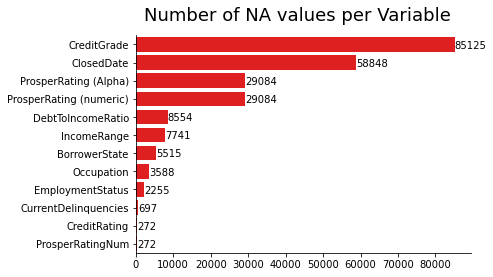

In [17]:
# explicit figure and figsize declaration
fig, axes = plt.subplots(1,1)
sb.despine(fig)

# plot missing values in descending order
g0 = sb.barplot(x=Nan_sublist.values, y=Nan_sublist.index, ax=axes, color='red', order=Nan_sublist.sort_values(ascending=False).index )

yplot_values(g0, '{:1.0f}'); # plot y values onto graph
fig.suptitle('Number of NA values per Variable', fontsize=18);

In [18]:
# slice object, convert to list and check datatype
subset_drop = Nan_sublist.sort_values(ascending=False)[4:].index.tolist()

In [19]:
# drop Nan values
loans_df.dropna(axis=0, subset=subset_drop, inplace=True)

In [20]:
# filter employmentstatus and income range
loans_df = loans_df[(loans_df.EmploymentStatus!='Not available')& (loans_df.IncomeRange!='Not displayed')]

## Distribution of Borrower Rate

The violin plot provides a holistic overview of the **BorrowerRate** distribution as well as indicating the *median* and *IQR*.
<br>
The hist plots support the information portrayed in the violin plot providing a numerical scale of the spread. 
<br>
The logarithmic plot is used to catch values difficult to see in the regular plot.
<br>
Generally, the **BorrowerRate** distribution is multimodal evident with the three peaks.

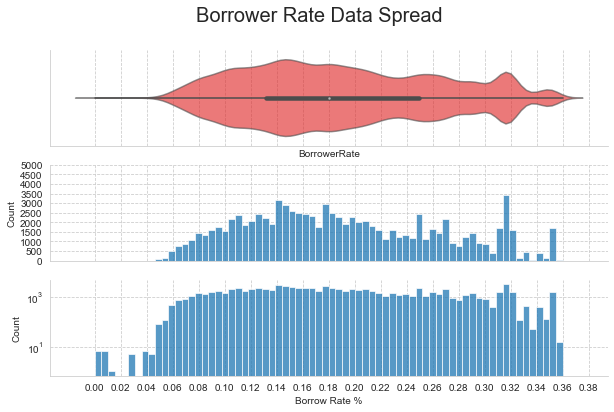

In [21]:
# initialize
sb.set_style("whitegrid", {'grid.linestyle': '--'})
fig, axes = plt.subplots(3,1, figsize=(10, 6), sharex=True)
sb.despine(fig)

# set ticks
minTickBorrow = np.arange(0, loans_df.BorrowerRate.max()+0.04, 0.02)

# graph 1
g0 = sb.violinplot(x=loans_df.BorrowerRate, color='Red', ax=axes[0]) # graph 1
plt.setp(g0.collections, alpha=.6)
g0.set(xticks=minTickBorrow)

# graph 2 - distribution of borrow rates
g1 = sb.histplot(loans_df, x='BorrowerRate', element='bars', multiple="stack", 
  ax=axes[1]);
g1.set(xticks = minTickBorrow, 
  yticks=np.arange(0,5500,500))

# graph 3
axes[2].set(yscale="log") # scale y axis only
g2 = sb.histplot(loans_df, x='BorrowerRate', element='bars', multiple="stack",
  #log_scale=True, # log scales both x & y
  ax=axes[2]);
g2.set(xticks = minTickBorrow, xlabel='Borrow Rate %')

fig.suptitle('Borrower Rate Data Spread', fontsize=20);
plt.show();

## Distribution of Employment Status
Employment status is a criteria that influences the loanees borrowing power, thus affecting the rate they are provided. Of the employment types, **Full-time** has the best guarantee of having low **BorrowRates** evident with the width/frequency between *0.08-0.1%* being more dominant then other types. **Full-time** also has the lowest first quartile.

In [22]:
# mask to filter out employed and other status
employment_mask=~loans_df['EmploymentStatus'].isin(['Employed', 'Other'])

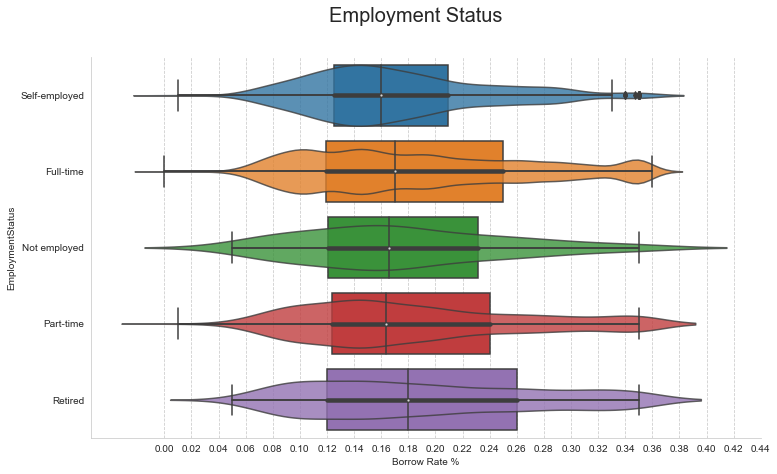

In [23]:
# initialize
sb.set_style("whitegrid", {'grid.linestyle': '--'})
fig, axes = plt.subplots(1,1, figsize=(12, 7))
sb.despine(fig)

# prepare ticks
minTickBorrow = np.arange(0, loans_df.BorrowerRate.max()+0.1, 0.02)

# graph 1
g0 = sb.violinplot(data=loans_df[employment_mask], x='BorrowerRate', y='EmploymentStatus', ax=axes);
plt.setp(g0.collections, alpha=.8)

# graph 2
g1 = sb.boxplot(data=loans_df[employment_mask], x='BorrowerRate', y='EmploymentStatus', ax=axes);
g1.set(xticks = minTickBorrow, xlabel='Borrow Rate %');

fig.suptitle('Employment Status', fontsize=20);

## Distribution of Income Range
**Income range** is deemed to have an impact on the **BorrowerRate** evident with higher incomes having the lowest rates, specifically there *medians, interquartile range (IQR)* and with the tail having a smaller width from 0.20% onwards.
<br>
This makes sense as they have a better ability to pay back the loan due to the larger income available to them.

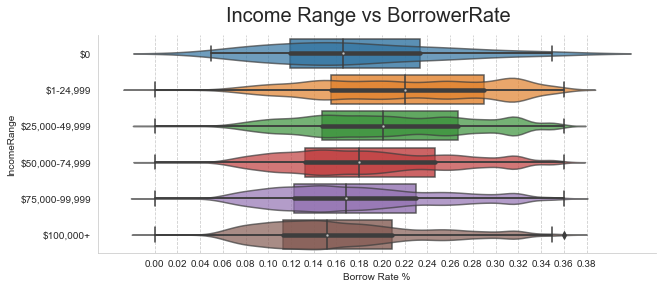

In [24]:
# initialize
fig, axes = plt.subplots(1,1, figsize=(10,4) )
sb.despine(fig)

# graph 1 - distribution of Income range
g0 = sb.violinplot(data = loans_df, x='BorrowerRate', y='IncomeRange', ax=axes);
plt.setp(g0.collections, alpha=0.7);

# graph 2
g1 = sb.boxplot(data = loans_df, x='BorrowerRate', y='IncomeRange', boxprops=dict(alpha=0.8), ax=axes);
g1.set(xticks=np.arange(0,loans_df.BorrowerRate.max()+0.04, 0.02), xlabel='Borrow Rate %');

plt.suptitle('Income Range vs BorrowerRate', fontsize=20);

## BorrowerRate by Credit Rating
**Credit Rating** is one of the main variables that contribute to having a lower borrow rate on a loan. 
<br>
The graph below clearly depicts the distribution of each respective rating, with *AA* rating being prevalent in the lower borrower rate regions soon followed after by the subsequent ratings *A* through to *HR (high risk)*.

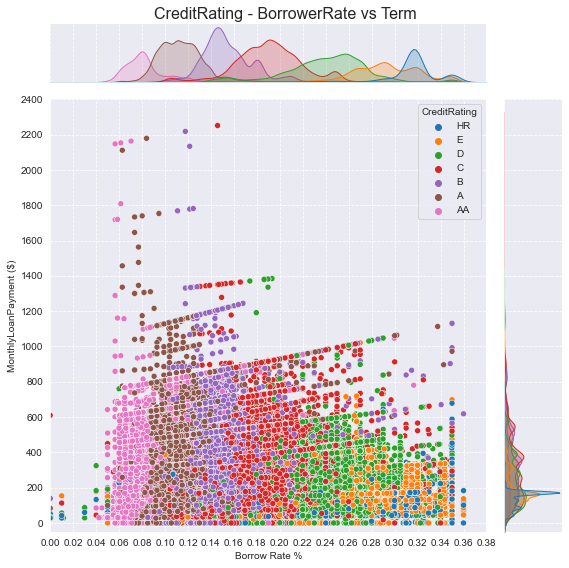

In [25]:
# define figure and num. axes
sb.set_style("darkgrid", {'grid.linestyle': '--'})
sb.despine(fig)

g0 = sb.jointplot(data=loans_df, x='BorrowerRate', y='MonthlyLoanPayment', hue=loans_df['CreditRating'], hue_order=ordinal_dict['CreditGrade'],
  kind='scatter', height=8, ratio=6, space=0.3, xlim=(0, 0.38), ylim=(-50, 2400) );

# set labels
g0.set_axis_labels(xlabel='Borrow Rate %', ylabel='MonthlyLoanPayment ($)')

# set x/y axis values
g0.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
g0.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(200));

# set title
g0.fig.subplots_adjust(top=0.95) # adjust offset from top
g0.fig.suptitle('CreditRating - BorrowerRate vs Term', fontsize=16);

## Exploration of Occupations

After analysing the key variables that effect **Borrower Rates**, we delve into the **Occupations** that ultimately show if there is preferential treatment, a set of rates provided to a specific Occupation.
<br>
<br>
It is evident that **Occupations** such as *Judges* and *Doctors* appearing to have the lowest *median* borrow rates, where as *Student College Freshman* and *Teachers aid* appear to have the highest.

In [26]:
# sliced list omitting Professional and Other
key_occp_list = loans_df.Occupation.value_counts().index[2:11].to_list()

# custom selection of Occupations to incorporate one from each field of work
custom_occp_list = ['Police Officer/Correction Officer', 'Fireman', 
                    'Attorney', 'Engineer - Mechanical', 
                    'Doctor', 'Judge', 'Investor', 'Sales - Retail',
                    'Student - College Freshman', 'Student - College Graduate Student']

sample_occp_list = key_occp_list + custom_occp_list # append both lists into one
sample_occp_mask = loans_df.Occupation.isin(sample_occp_list)

In [27]:
def occ_boxplot(gx, occ_name, size):
  # function to replicate box plot

  # initialize
  fig, axes = plt.subplots(1, 1, figsize=(size))
  sb.despine(fig)

  gx = sb.boxplot(data=loans_df,
        y=loans_df[loans_df['Occupation'].str.contains(pat=occ_name,regex=False)].Occupation,
        x='BorrowerRate', ax=axes,
        hue='EmploymentStatus');
  gx.set(xticks=np.arange(0,loans_df.BorrowerRate.max()+0.04, 0.02));

# legend modifications
  gx.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
  fig.suptitle(occ_name+' Employment Status vs Borrower Rate', fontsize=20);

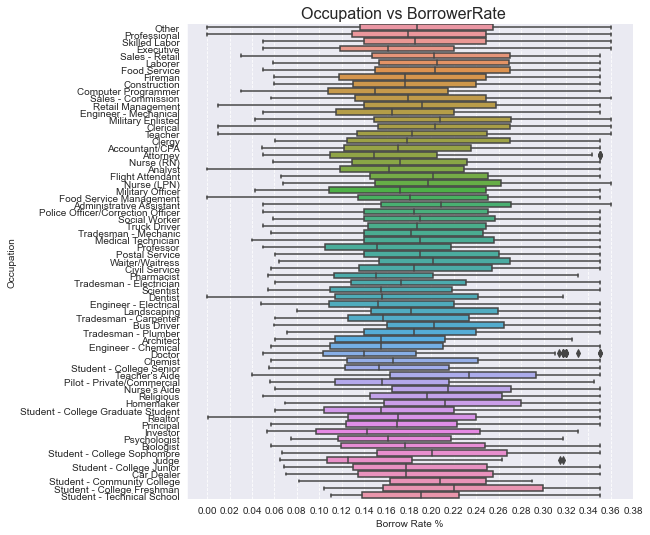

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sb.despine(fig)

g1 = sb.boxplot(y=loans_df.Occupation, x=loans_df.BorrowerRate, hue_order=loans_df.BorrowerRate.median);
g1.set(xticks = np.arange(0, loans_df['BorrowerRate'].max()+0.04, 0.02), xlabel='Borrow Rate %'); #preset variables

fig.subplots_adjust(top=0.95) # adjust offset
fig.suptitle('Occupation vs BorrowerRate', fontsize=16);

plt.show();

In [29]:
!jupyter nbconvert "Loans Part 2.ipynb" --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Loans Part 2.ipynb to slides
[NbConvertApp] Writing 1235439 bytes to Loans Part 2.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\jcala\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\jcala\anaconda3\lib\site-packages\jupyter_core\application.py", line 254, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\jcala\anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\jcala\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 350, in start
    self.convert_notebooks()
  File "C:\Users\jcala\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 524, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "C:\Users\jc